In [1]:
# import

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Training hyperparameters

epochs = 10
batch_size = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 20
weight_decay = 0

criterion = nn.CrossEntropyLoss()

In [3]:
# load CNN network module

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        # self.fc1 = nn.Linear(in_features=576, out_features=128)
        # self.fc2 = nn.Linear(in_features=128, out_features=10)
        #
        # self.batch0 = nn.BatchNorm2d(num_features=728)
        # self.batch1 = nn.BatchNorm2d(num_features=16)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(32)

        nn.init.xavier_uniform_(self.conv1.weight)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(64)

        nn.init.xavier_uniform_(self.conv2.weight)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4096, 4096)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.norm1(out)

        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.norm2(out)

        out = self.maxpool2(out)

        out = out.view(out.size(0),-1)

        out = self.fc1(out)
        out = self.relu3(out)

        out = self.fc2(out)

        return out

In [4]:
# load function

def plot_data(data, label, text):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.tight_layout()
        plt.imshow(data.cpu()[i][0], cmap='gray', interpolation='none')
        plt.title(text + ": {}".format(label[i]))
        # plt.title(text + ": {}".format(fashion[label[i]]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

def predict_batch(model, device, test_loader):
    examples = enumerate(test_loader)
    model.eval()
    with torch.no_grad():
        batch_idx, (data, target) = next(examples)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        # pred = output.cpu().data.max(1, keepdim=True)[1] # get the index of the max log-probability
        pred = pred.cpu().numpy()
    return data, target, pred

def plot_graph(train_x, train_y, test_x, test_y, ylabel=''):
    fig = plt.figure()
    plt.plot(train_x, train_y, color='blue')
    plt.plot(test_x, test_y, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def train(model, device, train_loader, optimizer, epoch, losses=[], counter=[], errors=[]):
    model.train()
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
            counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    errors.append(100. * (1 - correct / len(train_loader.dataset)))

def test(model, device, test_loader, losses=[], errors=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += criterion(output, target).item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    losses.append(test_loss)
    errors.append(100. *  (1 - correct / len(test_loader.dataset)))

def save_predictions(model, device, test_loader, path):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.softmax(model(data), dim=1)
            with open(path, "a") as out_file:
                np.savetxt(out_file, output.cpu())

In [5]:
if __name__ == '__main__':
# load device

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print("cuda" if use_cuda else "cpu")

cuda


In [6]:
    # load dataset

    # data transformation
    train_data = datasets.FashionMNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    test_data = datasets.FashionMNIST('./data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

    # data loaders
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
    # initial CNN model
    model = CNN().to(device)
    # optimizer creation
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov = True)

In [8]:
    # lists for saving history
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
    train_errors = []
    test_errors = []
    error_counter = [i*len(train_loader.dataset) for i in range(epochs)]

In [9]:
    # test of randomly initialized model
    test(model, device, test_loader, losses=test_losses)

    # global training and testing loop
    for epoch in range(1, epochs + 1):
       train(model, device, train_loader, optimizer, epoch, losses=train_losses, counter=train_counter, errors=train_errors)
       test(model, device, test_loader, losses=test_losses, errors=test_errors)


Test set: Average loss: 0.0362, Accuracy: 431/10000 (4%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.366394
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.799963
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.566362
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.555171
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.576855
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.416696
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.406973
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.341274
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.384015
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.471942
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.424184
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.580701
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.239170
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.412153
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.425077
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.320164
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.398404
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.383006
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.514167
Train E

Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.181197
Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.128613
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.095044
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.256840
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.120707
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.190513
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.292599
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.285296
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.180028
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.365019
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.190225
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.219929
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.116477
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.256211
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.193709
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.196642
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.148788
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.221424
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.188591
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.112600


Train Epoch: 7 [52480/60000 (87%)]	Loss: 0.179290
Train Epoch: 7 [53760/60000 (90%)]	Loss: 0.088978
Train Epoch: 7 [55040/60000 (92%)]	Loss: 0.106560
Train Epoch: 7 [56320/60000 (94%)]	Loss: 0.209028
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.063519
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.105441

Test set: Average loss: 0.0041, Accuracy: 9147/10000 (91%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.045396
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.086983
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.038088
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.119648
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.082518
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.069264
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.067792
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.054650
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.185297
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.025881
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.115039
Train Epoch: 8 [14080/60000 (23%)]	Loss: 0.056622
Train Epoch: 8 [15360/60000 (26%)]	Loss: 0.163149
Train

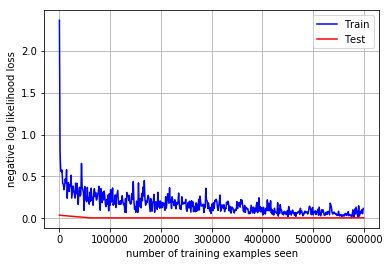

In [11]:
    plot_graph(train_counter, train_losses, test_counter, test_losses, ylabel='negative log likelihood loss')

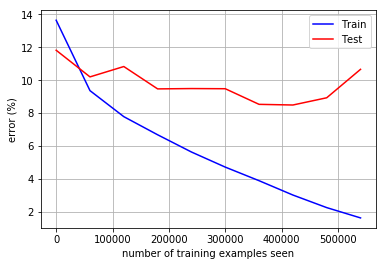

In [12]:
    plot_graph(error_counter, train_errors, error_counter, test_errors, ylabel='error (%)')

In [13]:
    # extract and plot random samples of data with predicted labels
    data, _, pred = predict_batch(model, device, test_loader)
    plot_data(data, pred, 'Predicted')

RuntimeError: cuda runtime error (4) : unspecified launch failure at /build/python-pytorch/src/pytorch-1.0rc1-cuda/aten/src/THC/generic/THCTensorCopy.cpp:21

In [14]:
    # save model
    torch.save(model.state_dict(), 'Model.pt')

    # save prediction
    save_predictions(model, device, test_loader, 'Predictions.txt')

RuntimeError: cuda runtime error (4) : unspecified launch failure at /build/python-pytorch/src/pytorch-1.0rc1-cuda/torch/csrc/generic/serialization.cpp:15